# Capstone Two - Modeling

On this capstone, we would be trying different models to try to predict the weekly sales at Walmart. 
The data frame we would be using has categorical features and some numeric features such as unemployment, cpi, etc was standarized. 
Some of the models we saw and may implement are:
1. K-Nearest Neighbors
2. Linear Regression
3. Decision Trees
4. Gradient Boosting

Depending on the results and what we are looking for, we would be selecting a model. 

The evaluation of the model is going to be based on the score, accuracy, and all the methods we have seen so far.

In [1]:
#Import Necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import seaborn as sns
import warnings

## Load the data

In [2]:
#Use pd.read_csv to read the data
df = pd.read_csv('walmart_sales.csv', index_col = 0)

In [3]:
#See how the data frame looks like
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Close,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,53.450001,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,211.096358,8.106,53.450001,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,211.096358,8.106,53.450001,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,211.096358,8.106,53.450001,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,211.096358,8.106,53.450001,A,151315


# Data Wrangling

Firstly, we are going to count the values per store and department in order to reduce the dimensionality of our data set and make more accurate predictions.

In [4]:
pd.set_option('max_rows', None)
pd.DataFrame(df['Store'].value_counts(ascending = True))

,Store
36,6048
33,6307
43,6563
42,6757
30,6951
44,6971
37,7000
38,7157
9,8620
5,8745


In [5]:
pd.set_option('max_rows', None)
pd.DataFrame(df['Dept'].value_counts(ascending = True))

,Dept
43,12
39,16
65,139
77,150
78,227
47,630
99,839
51,1340
50,1518
48,1693


Departments to be deleted

Departments 43, 39, 65, 77, 78, 47, 99, 51, 50, 48, 45

In [6]:
#Use of loc to remove the departments mentioned above
df =df.loc[~df['Dept'].isin([43, 39, 65, 77, 78, 47,99, 51, 50, 48, 45])]

#### Remove Outliers

In [7]:
#Outliers
std = df['Weekly_Sales'].std()
Q1 = df['Weekly_Sales'].quantile(0.25)
Q3 = df['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1

In [8]:
df = df.loc[df['Weekly_Sales'] >=  Q1 - 1.5*IQR]
df = df.loc[df['Weekly_Sales'] <= Q3 + 1.5*IQR]

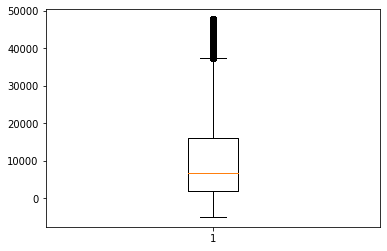

In [9]:
plt.boxplot(df['Weekly_Sales'])
plt.show()

### Feature Selection

We are making correlation matrix with the numerical features to see which ones we can remove.

- Low correlation (approximately 0) we may take off that feature.
- Features highly correlated between them may be removed as well.

In [10]:
#Create a data frame with just the numeric features
numeric_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Close', 'Size']
df_numeric = df[numeric_cols]

In [11]:
#Create the correlation matrix
corr_matrix = df_numeric.corr()

In [12]:
#See the complete correlation matrix
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
corr_matrix

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Close,Size
Weekly_Sales,1.000000,-0.001135,0.005084,-0.040834,-0.011384,-0.005120,0.229829
Temperature,-0.001135,1.000000,0.142896,0.176903,0.101041,0.098582,-0.060102
Fuel_Price,0.005084,0.142896,1.000000,-0.170773,-0.028173,0.468994,0.006035
CPI,-0.040834,0.176903,-0.170773,1.000000,-0.315650,0.062554,-0.008079
Unemployment,-0.011384,0.101041,-0.028173,-0.315650,1.000000,-0.217101,-0.062005
Close,-0.005120,0.098582,0.468994,0.062554,-0.217101,1.000000,-0.005236
Size,0.229829,-0.060102,0.006035,-0.008079,-0.062005,-0.005236,1.000000


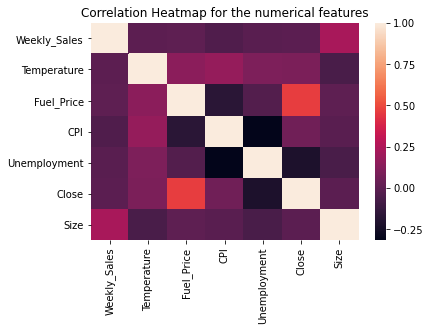

In [13]:
sns.heatmap(corr_matrix)
plt.title('Correlation Heatmap for the numerical features')
plt.show()

From the correlation matrix, we select the size of the store since it had an acceptable value of 0.22.The other ones were extremely too low.

# Creation of dummy variables

In [14]:
#Specify the dummies columns in a data frame
dummies_cols = ['Dept', 'Store', 'Type', 'IsHoliday']
df_dummies = df[dummies_cols]

In [15]:
#Use of pd.get_dummies to create the categorical features
df_dummies = pd.get_dummies(df_dummies, columns = ['Dept', 'Store', 'Type', 'IsHoliday'])

In [16]:
#Convert date to date time
df['Date'] = pd.to_datetime(df['Date'])

In [17]:
#Create a data frame with dates as categorical variable
df_date = pd.DataFrame()

df_date['Year'] = pd.Series(df['Date'])
df_date['Year'] = pd.DatetimeIndex(df_date['Year']).year

df_date['Month'] = pd.Series(df['Date'])
df_date['Month'] = pd.DatetimeIndex(df_date['Month']).month

df_date['Day'] = pd.Series(df['Date'])
df_date['Day'] = pd.DatetimeIndex(df_date['Day']).day

# Concat the dummies with the original data frame

In [18]:
#Drop the original columns for the categorical features since they are no longer necessary
df_categorical = df.drop(columns = {'Dept', 'Store', 'Type', 'Date', 'IsHoliday'}, axis = 1)

In [19]:
#Concat the data frames
df_categorical = pd.concat([df_date, df_categorical], axis = 1)
df_categorical = pd.concat([df_categorical, df_dummies], axis = 1)

In [20]:
#See how the final data frame looks like
df_categorical.head()

,Year,Month,Day,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Close,Size,Dept_1,Dept_2,Dept_3,Dept_4,Dept_5,Dept_6,Dept_7,Dept_8,Dept_9,Dept_10,Dept_11,Dept_12,Dept_13,Dept_14,Dept_16,Dept_17,Dept_18,Dept_19,Dept_20,Dept_21,Dept_22,Dept_23,Dept_24,Dept_25,Dept_26,Dept_27,Dept_28,Dept_29,Dept_30,Dept_31,Dept_32,Dept_33,Dept_34,Dept_35,Dept_36,Dept_37,Dept_38,Dept_40,Dept_41,Dept_42,Dept_44,Dept_46,Dept_49,Dept_52,Dept_54,Dept_55,Dept_56,Dept_58,Dept_59,Dept_60,Dept_67,Dept_71,Dept_72,Dept_74,Dept_79,Dept_80,Dept_81,Dept_82,Dept_83,Dept_85,Dept_87,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Store_1,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_17,Store_18,Store_19,Store_20,Store_21,Store_22,Store_23,Store_24,Store_25,Store_26,Store_27,Store_28,Store_29,Store_30,Store_31,Store_32,Store_33,Store_34,Store_35,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45,Type_A,Type_B,Type_C,IsHoliday_False,IsHoliday_True
0,2010,2,5,24924.50,42.31,2.572,211.096358,8.106,53.450001,151315,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,2010,2,5,13740.12,42.31,2.572,211.096358,8.106,53.450001,151315,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,2010,2,5,39954.04,42.31,2.572,211.096358,8.106,53.450001,151315,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,2010,2,5,32229.38,42.31,2.572,211.096358,8.106,53.450001,151315,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
5,2010,2,5,5749.03,42.31,2.572,211.096358,8.106,53.450001,151315,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


# Feature Selection Categorical Variables

We will be creating a correlation matrix same as we did with the numerical features and the selection process would be the same.

In [21]:
#Create a correlation matrix with the categorical features
df_sales = df['Weekly_Sales']
df_corr2 = df_categorical.iloc[:, 11:]
df_corr2 = pd.concat([df_sales, df_corr2], axis = 1)

In [22]:
corr_matrix2 = df_corr2.corr()
corr_matrix2

,Weekly_Sales,Dept_2,Dept_3,Dept_4,Dept_5,Dept_6,Dept_7,Dept_8,Dept_9,Dept_10,Dept_11,Dept_12,Dept_13,Dept_14,Dept_16,Dept_17,Dept_18,Dept_19,Dept_20,Dept_21,Dept_22,Dept_23,Dept_24,Dept_25,Dept_26,Dept_27,Dept_28,Dept_29,Dept_30,Dept_31,Dept_32,Dept_33,Dept_34,Dept_35,Dept_36,Dept_37,Dept_38,Dept_40,Dept_41,Dept_42,Dept_44,Dept_46,Dept_49,Dept_52,Dept_54,Dept_55,Dept_56,Dept_58,Dept_59,Dept_60,Dept_67,Dept_71,Dept_72,Dept_74,Dept_79,Dept_80,Dept_81,Dept_82,Dept_83,Dept_85,Dept_87,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Store_1,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_17,Store_18,Store_19,Store_20,Store_21,Store_22,Store_23,Store_24,Store_25,Store_26,Store_27,Store_28,Store_29,Store_30,Store_31,Store_32,Store_33,Store_34,Store_35,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45,Type_A,Type_B,Type_C,IsHoliday_False,IsHoliday_True
Weekly_Sales,1.000000,0.133158,-0.006916,0.138860,0.072274,-0.068534,0.077685,0.149747,0.067914,0.074870,0.037969,-0.075999,0.156146,0.038136,0.009705,-0.007799,-0.055923,-0.083951,-0.058757,-0.067581,-0.000928,0.109993,-0.047478,-0.021477,-0.035112,-0.099247,-0.114354,-0.054283,-0.069676,-0.094697,-0.046338,-0.046297,0.047292,-0.082346,-0.091640,-0.055688,0.169664,0.159161,-0.093265,-0.064341,-0.065424,0.091155,-0.025303,-0.100833,-0.105638,-0.008811,-0.077770,-0.067242,-0.114153,-0.113916,-0.039646,-0.053021,0.124295,0.032602,0.106961,0.015171,0.053067,0.044686,-0.082038,-0.095449,0.020936,0.084958,0.080956,0.118814,0.079862,0.081573,0.149174,0.042631,0.039439,-0.043877,0.034021,0.053571,-0.082057,0.049756,-0.087008,0.060480,-0.038337,0.000637,-0.043005,0.047446,0.046091,0.017564,0.053737,0.043153,-0.036164,-0.048922,-0.003276,0.012525,0.036326,0.057552,-0.002934,0.002774,0.059535,0.030902,-0.012853,-0.006343,0.053989,0.033795,-0.040189,-0.049242,0.000694,-0.000553,-0.058740,0.004202,0.015705,-0.036817,-0.042958,-0.052240,0.027531,0.002249,0.019310,-0.036467,-0.036667,-0.061586,-0.011932,0.152151,-0.079320,-0.120031,-0.006961,0.006961
Dept_2,0.133158,1.000000,-0.012983,-0.012601,-0.012654,-0.012704,-0.012600,-0.012256,-0.012617,-0.013001,-0.013123,-0.013157,-0.012088,-0.013110,-0.012824,-0.013156,-0.011408,-0.010515,-0.012761,-0.013183,-0.012221,-0.012075,-0.012064,-0.013097,-0.012440,-0.012307,-0.012856,-0.011956,-0.011936,-0.012797,-0.012669,-0.012048,-0.011937,-0.011943,-0.011940,-0.008300,-0.007529,-0.009916,-0.012049,-0.013150,-0.012141,-0.013005,-0.010985,-0.013008,-0.011313,-0.012222,-0.012567,-0.010859,-0.012837,-0.012479,-0.013183,-0.011956,-0.009466,-0.013144,-0.012846,-0.012601,-0.013168,-0.013120,-0.012623,-0.012783,-0.013015,-0.009852,-0.010971,-0.007956,-0.011378,-0.010279,-0.007716,-0.011409,-0.013018,-0.012540,0.004306,-0.014912,0.009796,-0.014535,0.009839,-0.006528,0.008385,0.008386,0.010275,-0.014656,-0.015167,-0.015660,-0.014816,-0.014472,0.008269,0.009141,0.007441,-0.015136,-0.009089,-0.014483,-0.002600,-0.013543,-0.015411,0.008124,0.007970,0.009428,-0.015114,-0.015653,0.008661,0.015000,-0.015316,-0.009806,0.016136,0.008382,0.002181,0.017471,0.015203,0.013840,-0.015022,0.008666,-0.002252,0.016092,0.017478,0.014157,0.008722,-0.028997,0.004835,0.039190,-0.001140,0.001140
Dept_3,-0.006916,-0.012983,1.000000,-0.016290,-0.016360,-0.016424,-0.016289,-0.015845,-0.016312,-0.016807,-0.016965,-0.017010,-0.015627,-0.016949,-0.016579,-0.017009,-0.014748,-0.013594,-0.016497,-0.017043,-0.015799,-0.015611,-0.015597,-0.016932,-0.016082,-0.015910,-0.016620,-0.015456,-0.015430,-0.016544,-0.016378,-0.015576,-0.015432,-0.015440,-0.015437,-0.010730,-0.009734,-0.012819,-0.015577,-0.017000,-0.015696,-0.016813,-0.014202,-0.016817,-0.014626,-0.015801,-0.016247,-0.014038,-0.016596,-0.016134,-0.017043,-0.015456,-0.012238,-0.016993,-0.016607,-0.016290,-0.017024,-0.016961,-0.016319,-0.016526,-0.016826,-0.012737,-0.014184,-0.010285,-0.014710,-0.013

We are selecting Department: 2, 4, 8, 13, 23, 28, 38, 40, 52, 54, 59, 60, 72, 79, 92, 95; and Type of store

# Variance for feature selection

We will run a variance test to remove the features with lowest variance and double check the process selection did with the correlation test.

In [23]:
from sklearn.feature_selection import VarianceThreshold

In [24]:
#Establish the array with the values
X = df_numeric.values

In [25]:
#Run the variance test
sel = VarianceThreshold(threshold= 0.5)
sel = sel.fit_transform(X)

In [26]:
#See the final data frame
pd.DataFrame(sel, columns = ['Weekly_Sales', 'Temperature', 'CPI', 'Unemployment', 'Close', 'Size'])

,Weekly_Sales,Temperature,CPI,Unemployment,Close,Size
0,24924.50,42.31,211.096358,8.106,53.450001,151315.0
1,13740.12,42.31,211.096358,8.106,53.450001,151315.0
2,39954.04,42.31,211.096358,8.106,53.450001,151315.0
3,32229.38,42.31,211.096358,8.106,53.450001,151315.0
4,5749.03,42.31,211.096358,8.106,53.450001,151315.0
...,...,...,...,...,...,...
367697,16330.84,58.85,192.308899,8.667,75.110001,118221.0
367698,2487.80,58.85,192.308899,8.667,75.110001,118221.0
367699,5203.31,58.85,192.308899,8.667,75.110001,118221.0
367700,6817.48,58.85,192.308899,8.667,75.110001,118221.0


By doing a variance test, we are removing the Fuel Price.

# Train and test split

In [27]:
df = df.loc[df['Dept'].isin([2, 4, 8, 13, 23, 28, 38, 40, 52, 54, 59, 60, 72, 79, 92, 95])]

In [28]:
#Specify the dummies columns in a data frame
dummies_cols = ['Dept', 'Store', 'Type', 'IsHoliday']
df_dummies = df[dummies_cols]

In [29]:
#Use of pd.get_dummies to create the categorical features
df_dummies = pd.get_dummies(df_dummies, columns = ['Dept', 'Store', 'Type', 'IsHoliday'])

In [30]:
#Convert date to date time
df['Date'] = pd.to_datetime(df['Date'])

In [31]:
#Create a data frame with dates as categorical variable
df_date = pd.DataFrame()

df_date['Year'] = pd.Series(df['Date'])
df_date['Year'] = pd.DatetimeIndex(df_date['Year']).year

df_date['Month'] = pd.Series(df['Date'])
df_date['Month'] = pd.DatetimeIndex(df_date['Month']).month

df_date['Day'] = pd.Series(df['Date'])
df_date['Day'] = pd.DatetimeIndex(df_date['Day']).day

In [32]:
#Drop the original columns for the categorical features since they are no longer necessary
df_categorical = df.drop(columns = {'Dept', 'Store', 'Type', 'Date', 'IsHoliday'}, axis = 1)

In [33]:
#Concat the data frames
df_categorical = pd.concat([df_date, df_categorical], axis = 1)
df_categorical = pd.concat([df_categorical, df_dummies], axis = 1)

In [34]:
#Define the final data frame
df_mod = df_categorical[['Year', 'Month', 'Day','Weekly_Sales', 'Size','Dept_2','Dept_4', 'Dept_8', 'Dept_13', 
                         'Dept_23', 'Dept_28', 'Dept_38', 'Dept_40', 'Dept_52', 'Dept_54', 'Dept_59', 'Dept_60', 
                         'Dept_72', 'Dept_79', 'Dept_92' , 'Dept_95', 'Type_A', 'Type_B', 'Type_C']]

In [35]:
df_mod.head()

,Year,Month,Day,Weekly_Sales,Size,Dept_2,Dept_4,Dept_8,Dept_13,Dept_23,Dept_28,Dept_38,Dept_40,Dept_52,Dept_54,Dept_59,Dept_60,Dept_72,Dept_79,Dept_92,Dept_95,Type_A,Type_B,Type_C
3,2010,2,5,39954.04,151315,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
7,2010,2,5,40129.01,151315,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
12,2010,2,5,41969.29,151315,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
21,2010,2,5,24146.49,151315,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
26,2010,2,5,1085.29,151315,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [36]:
#Define the arrays
X = df_mod.drop(columns = {'Weekly_Sales', 'Year', 'Month', 'Day'}, axis = 1).values
y = df_mod['Weekly_Sales'].values

In [37]:
#Divide into train and test data
X_train = X[:int(X.shape[0]*0.75)]
y_train = y[:int(y.shape[0]*0.75)]
X_test = X[int(X.shape[0]*0.75):]
y_test = y[int(y.shape[0]*0.75):]

In [38]:
#Use Standard Scaler to run the test with and without a scaler
X2 = df_mod['Size'].values.reshape(-1,1)
y2 = df_mod['Weekly_Sales'].values

In [39]:
from sklearn.preprocessing import StandardScaler
# Making a Scaler object
scaler = StandardScaler()
# Fitting data to the scaler object
scaler_transformed = scaler.fit_transform(X2)

In [40]:
#Do some data wrangling to have the standarized data with the dummies variables that were not standarized
df_date = pd.DataFrame()
df_date['Year'] = df_mod['Year']
df_date['Month'] = df_mod['Month']
df_date['Day'] = df_mod['Day']
df_sales = pd.DataFrame()
df_sales['Weekly_Sales'] = df_mod['Weekly_Sales']
df_scaled = pd.DataFrame(data = scaler_transformed, columns = ['Size'])
df_dummies = df_mod.iloc[:, 5:]

In [41]:
#See the second data frame where we are going to run the test with the standarized values
df_mod2 = pd.concat([df_date, df_sales], axis = 1)
df_mod2 = pd.concat([df_mod2, df_scaled], axis = 1)
df_mod2 = pd.concat([df_mod2, df_dummies], axis = 1)
df_mod2.dropna(inplace = True)

In [42]:
df_mod2.head()

,Year,Month,Day,Weekly_Sales,Size,Dept_2,Dept_4,Dept_8,Dept_13,Dept_23,Dept_28,Dept_38,Dept_40,Dept_52,Dept_54,Dept_59,Dept_60,Dept_72,Dept_79,Dept_92,Dept_95,Type_A,Type_B,Type_C
3,2010.0,2.0,5.0,39954.04,0.459015,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,2010.0,2.0,5.0,40129.01,0.459015,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12,2010.0,2.0,5.0,41969.29,0.459015,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21,2010.0,2.0,5.0,24146.49,0.459015,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26,2010.0,2.0,5.0,1085.29,0.459015,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [43]:
#Define the other 2 arrays to make comparison with the tests. 
X2 = df_mod2.drop(columns = {'Weekly_Sales', 'Year', 'Month', 'Day'}, axis = 1).values
y2 = df_mod2['Weekly_Sales'].values

In [44]:
#Split the data for the second array
X_train2 = X2[:int(X2.shape[0]*0.75)]
y_train2 = y2[:int(y2.shape[0]*0.75)]
X_test2 = X2[int(X2.shape[0]*0.75):]
y_test2 = y2[int(y2.shape[0]*0.75):]

# Modeling

### Linear Regression

In [45]:
#Define function to make cross validation
def grid_search(model, param_grid, cv = 3):
    model = model()
    model_cv = GridSearchCV(model, param_grid, cv = 3)
    model_cv.fit(X_train, y_train)
    print('Based on the Cross Validation, the best parameters were:',
          model_cv.best_params_, 'with a score of:', model_cv.best_score_)

### Standard Linear Regression

#### Without Scaler

In [46]:
#Import library and run the test
from sklearn.linear_model import LinearRegression

# Run the function, fit and predict
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred1 = reg.predict(X_test)

In [47]:
#Print the scores of the test and train set
print('The R-Square of the train data set is:', reg.score(X_train, y_train))
print('The R-Square of the test data set is:', reg.score(X_test, y_test))

The R-Square of the train data set is: 0.7842889997003972
The R-Square of the test data set is: 0.6237532888953792


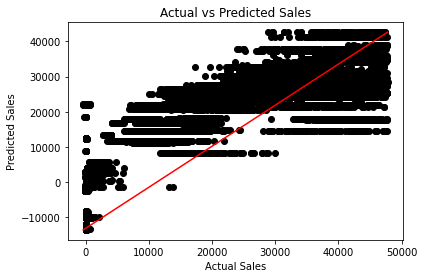

In [48]:
#Plot the results
plt.scatter(y_test, y_pred1, color = 'black')
x0 = min(y_test)
x1 = max(y_test)
y0 = min(y_pred1)
y1 = max(y_pred1)
plt.plot([x0,x1], [y0, y1], color = 'red')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()

As we can see, the R-Square is not that good, we would be trying different linear functions to see our best model


#### With scaler

In [49]:
#Same pricess than above, but with Standard Scaler
reg = LinearRegression()
reg.fit(X_train2, y_train2)
y_pred1 = reg.predict(X_test2)

In [50]:
#Print the score of the test and train set
print('The R-Square of the train data set is:', reg.score(X_train2, y_train2))
print('The R-Square of the test data set is:', reg.score(X_test2, y_test2))

The R-Square of the train data set is: 0.7811741570467451
The R-Square of the test data set is: 0.5206344110393528


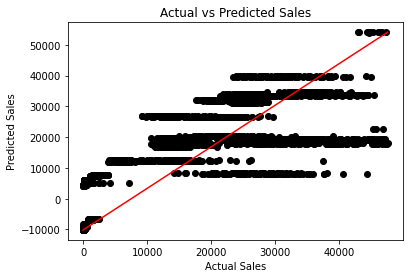

In [51]:
#Plot the results
plt.scatter(y_test2, y_pred1, color = 'black')
x0 = min(y_test2)
x1 = max(y_test2)
y0 = min(y_pred1)
y1 = max(y_pred1)
plt.plot([x0,x1], [y0, y1], color = 'red')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()

### Lasso Regression

#### Without Scaler

In [52]:
#Import necessary modules
from sklearn.linear_model import Lasso

In [53]:
warnings. filterwarnings(action = 'ignore')
#Run, fit and predict using Lasso 
lasso= Lasso(alpha = 0.2, max_iter = 1000)
lasso.fit(X_train, y_train)
y_pred2 = lasso.predict(X_test)

In [54]:
#Print the score of the test and train set
print('The R-Square of the train data set is:', lasso.score(X_train, y_train))
print('The R-Square of the test data set is:', lasso.score(X_test, y_test))

The R-Square of the train data set is: 0.7842889494756928
The R-Square of the test data set is: 0.6238118126482202


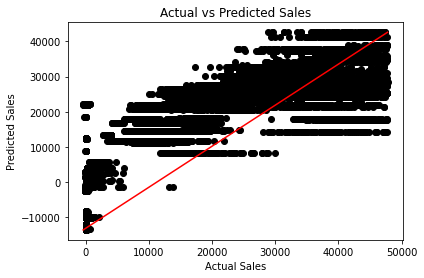

In [55]:
#Plot the results
plt.scatter(y_test, y_pred2, color = 'black')
x0 = min(y_test)
x1 = max(y_test)
y0 = min(y_pred2)
y1 = max(y_pred2)
plt.plot([x0,x1], [y0, y1], color = 'red')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()

#### With Scaler

In [56]:
#With the Standard Scaler
warnings. filterwarnings(action = 'ignore')
warnings. filterwarnings(action = 'ignore')
lasso= Lasso(alpha = 0.2, max_iter = 1000)
lasso.fit(X_train2, y_train2)
y_pred2 = lasso.predict(X_test2)

In [57]:
#Print the score of the test and train set
print('The R-Square of the train data set is:', lasso.score(X_train2, y_train2))
print('The R-Square of the test data set is:', lasso.score(X_test2, y_test2))

The R-Square of the train data set is: 0.781189035466495
The R-Square of the test data set is: 0.5215128507599176


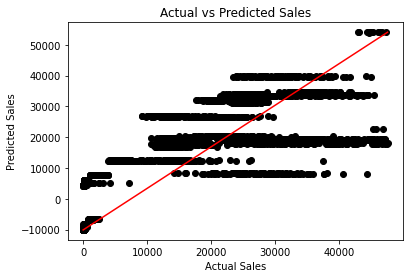

In [58]:
#Plot the results
plt.scatter(y_test2, y_pred2, color = 'black')
x0 = min(y_test2)
x1 = max(y_test2)
y0 = min(y_pred2)
y1 = max(y_pred2)
plt.plot([x0,x1], [y0, y1], color = 'red')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()

### Ridge Regression

#### Without scaler

In [59]:
#Import necessary libraries
from sklearn.linear_model import Ridge

In [60]:
#Establish the parameters for the grid search
param_grid = {'alpha': [0.2, 0.4, 0.6, 0.8, 1.0],
             'normalize': [False, True],
             'random_state': [None, 42, 123],
             'tol': [0.001, 0.01, 0.1, 1]
             }

In [61]:
#Print the best parameters
warnings. filterwarnings(action = 'ignore')
grid_search(Ridge, param_grid, cv = 3)

Based on the Cross Validation, the best parameters were: {'alpha': 1.0, 'normalize': False, 'random_state': None, 'tol': 0.001} with a score of: 0.755818886189461


In [62]:
#Run, fit and predict with the parameters above.
warnings. filterwarnings(action = 'ignore')
ridge = Ridge(alpha = 0.4, normalize = False, tol = 0.001)
ridge.fit(X_train, y_train)
y_pred3 = ridge.predict(X_test)

In [63]:
#Print the score of the test and train set
print('The R-Square of the train data set is:', ridge.score(X_train, y_train))
print('The R-Square of the test data set is:', ridge.score(X_test, y_test))

The R-Square of the train data set is: 0.784288985205594
The R-Square of the test data set is: 0.6237815425633102


In [64]:
#Name of the rows for the coefficient data frame
index = ['Size','Dept_2','Dept_4', 'Dept_8', 'Dept_13', 
                         'Dept_23', 'Dept_28', 'Dept_38', 'Dept_40', 'Dept_52', 'Dept_54', 'Dept_59', 'Dept_60', 
                         'Dept_72', 'Dept_79', 'Dept_92' , 'Dept_95', 'Type_A', 'Type_B', 'Type_C']

In [65]:
#Creation of the data frame
df_coeff = pd.DataFrame()
df_coeff['Variable'] = index
df_coeff['Coefficient'] = ridge.coef_

In [66]:
#Overview of the data frame
df_coeff

,Variable,Coefficient
0,Size,0.112373
1,Dept_2,10618.364816
2,Dept_4,4543.324614
3,Dept_8,6676.251731
4,Dept_13,7957.892468
5,Dept_23,2184.092968
6,Dept_28,-20384.491042
7,Dept_38,18354.745783
8,Dept_40,14367.160241
9,Dept_52,-18565.237979


In [67]:
#Calculation of the intercept
print('The model intercept is:',ridge.intercept_)

The model intercept is: 5077.499707964462


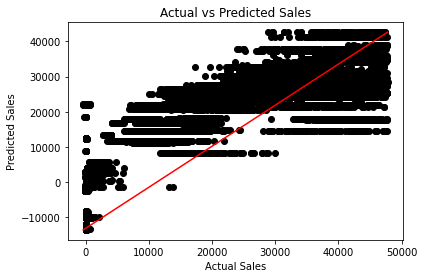

In [68]:
#Plot the results
plt.scatter(y_test, y_pred3, color = 'black')
x0 = min(y_test)
x1 = max(y_test)
y0 = min(y_pred3)
y1 = max(y_pred3)
plt.plot([x0,x1], [y0, y1], color = 'red')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()

#### With scaler

In [69]:
#Applying Standard Scaler
warnings. filterwarnings(action = 'ignore')
ridge = Ridge(alpha = 0.4, normalize = False, tol = 0.001)
ridge.fit(X_train2, y_train2)
y_pred3 = ridge.predict(X_test2)

In [70]:
#Print the score of the test and train set
print('The R-Square of the train data set is:', ridge.score(X_train2, y_train2))
print('The R-Square of the test data set is:', ridge.score(X_test2, y_test2))

The R-Square of the train data set is: 0.7811868415493542
The R-Square of the test data set is: 0.5227684042704676


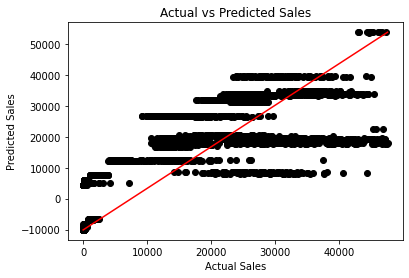

In [71]:
#Plot the results
plt.scatter(y_test2, y_pred3, color = 'black')
x0 = min(y_test2)
x1 = max(y_test2)
y0 = min(y_pred3)
y1 = max(y_pred3)
plt.plot([x0,x1], [y0, y1], color = 'red')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()

### Random Forest Regressor

#### Without Standarization

In [72]:
#Import necessary libraries
from sklearn.ensemble import RandomForestRegressor

In [73]:
#Run the test
reg = RandomForestRegressor(n_estimators = 30, max_depth = None, min_samples_split = 2)
reg.fit(X_train, y_train)
y_pred4 = reg.predict(X_test) 

In [74]:
#Calculate the score
print('We got a train score for Random Forest Regressor of:',reg.score(X_train, y_train))
print('We got a test score for Random Forest Regressor of:', reg.score(X_test, y_test))

We got a train score for Random Forest Regressor of: 0.9727621145090971
We got a test score for Random Forest Regressor of: 0.848940538563322


In [75]:
#Run the test
reg = RandomForestRegressor(n_estimators = 30, max_depth = 10, min_samples_split = 2)
reg.fit(X_train, y_train)
y_pred4 = reg.predict(X_test) 

In [76]:
#Calculate the score
print('We got a train score for Random Forest Regressor of:',reg.score(X_train, y_train))
print('We got a test score for Random Forest Regressor of:', reg.score(X_test, y_test))

We got a train score for Random Forest Regressor of: 0.8564080344658959
We got a test score for Random Forest Regressor of: 0.7600987271284105


#### Standarized data

In [77]:
#With the standarized data 
reg = RandomForestRegressor(n_estimators = 30, max_depth = None, min_samples_split = 2)
reg.fit(X_train2, y_train2)
y_pred4 = reg.predict(X_test2) 

In [78]:
print('We got a train score for Random Forest Regressor of:',reg.score(X_train2, y_train2))
print('We got a test score for Random Forest Regressor of:', reg.score(X_test2, y_test2))

We got a train score for Random Forest Regressor of: 0.9797037005472944
We got a test score for Random Forest Regressor of: 0.41907368106362053


In [79]:
#With the standarized data 
reg = RandomForestRegressor(n_estimators = 30, max_depth = 10, min_samples_split = 2)
reg.fit(X_train2, y_train2)
y_pred4 = reg.predict(X_test2) 

In [80]:
print('We got a train score for Random Forest Regressor of:',reg.score(X_train2, y_train2))
print('We got a test score for Random Forest Regressor of:', reg.score(X_test2, y_test2))

We got a train score for Random Forest Regressor of: 0.9631117488360763
We got a test score for Random Forest Regressor of: 0.42750051920187027


### Gradient Boosting Regression

#### Without Standarization

In [81]:
#Import necessary libraries
from sklearn.ensemble import GradientBoostingRegressor

In [82]:
#Run, fit and predict the test
model_gradient = GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 30, min_samples_split = 2,
                                           max_depth = None, tol = 0.0001)
model_gradient.fit(X_train, y_train)
y_pred5 = model_gradient.predict(X_test)

In [83]:
#Print the results
print('We got a train score for the Gradient Boosting Regressor of:',model_gradient.score(X_train, y_train))
print('We got a test score for the Gradient Boosting Regreesion of:', model_gradient.score(X_test, y_test))

We got a train score for the Gradient Boosting Regressor of: 0.9710321425496995
We got a test score for the Gradient Boosting Regreesion of: 0.8627017141783222


In [84]:
#Run, fit and predict the test
model_gradient = GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 30, min_samples_split = 2,
                                           max_depth = 10, tol = 0.0001)
model_gradient.fit(X_train, y_train)
y_pred5 = model_gradient.predict(X_test)

In [85]:
#Print the results
print('We got a train score for the Gradient Boosting Regressor of:',model_gradient.score(X_train, y_train))
print('We got a test score for the Gradient Boosting Regreesion of:', model_gradient.score(X_test, y_test))

We got a train score for the Gradient Boosting Regressor of: 0.9350715536634
We got a test score for the Gradient Boosting Regreesion of: 0.8371818362695939


In [86]:
#Create a data frame comparing actual values with predicted values
pred_df  = pd.DataFrame()
pred_df['Actual'] =  y_test
pred_df['Prediction'] = y_pred5

In [87]:
pd.set_option('max_rows', None)
pred_df.sample(15)

,Actual,Prediction
210,218.29,1873.866288
6427,212.00,1264.110290
1333,44221.87,37825.009790
15850,5336.06,8433.052129
9717,34013.39,44754.088605
12160,17054.79,10054.124617
17616,1320.92,3235.604859
12663,225.00,1015.933351
2485,9085.07,8228.916547
16425,35745.93,41453.350853


#### With standarization

In [88]:
#With the Standarized data
model_gradient = GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 30, min_samples_split = 2,
                                           max_depth = None, tol = 0.0001)
model_gradient.fit(X_train2, y_train2)
y_pred5 = model_gradient.predict(X_test2)

In [89]:
#Print the results
print('We got a train score for Random Forest Regressor of:',model_gradient.score(X_train2, y_train2))
print('We got a test score for Random Forest Regressor of:', model_gradient.score(X_test2, y_test2))

We got a train score for Random Forest Regressor of: 0.978029480855042
We got a test score for Random Forest Regressor of: 0.4461187816751788


In [90]:
#With the Standarized data
model_gradient = GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 30, min_samples_split = 2,
                                           max_depth = 10, tol = 0.0001)
model_gradient.fit(X_train2, y_train2)
y_pred5 = model_gradient.predict(X_test2)

In [91]:
#Print the results
print('We got a train score for Random Forest Regressor of:',model_gradient.score(X_train2, y_train2))
print('We got a test score for Random Forest Regressor of:', model_gradient.score(X_test2, y_test2))

We got a train score for Random Forest Regressor of: 0.9697052994248389
We got a test score for Random Forest Regressor of: 0.5314919374718541


### Decision Tree Regressor

#### Without standarization

In [92]:
# Decision Tree Regressor 
from sklearn.tree import DecisionTreeRegressor

In [93]:
#Run fit and predict
model_tree = DecisionTreeRegressor(max_depth = None)
model_tree.fit(X_train, y_train)
y_pred6 = model_tree.predict(X_test)

In [94]:
#Print the scores
print('We got a train score for Decision Tree Regressor of:',model_tree.score(X_train, y_train))
print('We got a test score for Decision Tree Regressor of:', model_tree.score(X_test, y_test))

We got a train score for Decision Tree Regressor of: 0.9727802386581214
We got a test score for Decision Tree Regressor of: 0.8160338952068449


In [95]:
#Run fit and predict
model_tree = DecisionTreeRegressor(max_depth = 10)
model_tree.fit(X_train, y_train)
y_pred6 = model_tree.predict(X_test)

In [96]:
#Print the scores
print('We got a train score for Decision Tree Regressor of:',model_tree.score(X_train, y_train))
print('We got a test score for Decision Tree Regressor of:', model_tree.score(X_test, y_test))

We got a train score for Decision Tree Regressor of: 0.8529913465085914
We got a test score for Decision Tree Regressor of: 0.753946920627235


#### With Standarization

In [97]:
#With the Standarized data
model_tree = DecisionTreeRegressor(max_depth = None)
model_tree.fit(X_train2, y_train2)
y_pred6 = model_tree.predict(X_test2)

In [98]:
#Print the scores
print('We got a train score for Decision Tree Regressor of:',model_tree.score(X_train2, y_train2))
print('We got a test score for Decision Tree Regressor of:', model_tree.score(X_test2, y_test2))

We got a train score for Decision Tree Regressor of: 0.979790173889276
We got a test score for Decision Tree Regressor of: 0.4081366145057682


In [99]:
#With the Standarized data
model_tree = DecisionTreeRegressor(max_depth = 10)
model_tree.fit(X_train2, y_train2)
y_pred6 = model_tree.predict(X_test2)

In [100]:
#Print the scores
print('We got a train score for Decision Tree Regressor of:',model_tree.score(X_train2, y_train2))
print('We got a test score for Decision Tree Regressor of:', model_tree.score(X_test2, y_test2))

We got a train score for Decision Tree Regressor of: 0.9575852209923308
We got a test score for Decision Tree Regressor of: 0.3415345875888718


# Conclusions

- Based on the results, Gradient Boosting Regression or a Random Forest Regressor may be the best regression models we can use to predict the sales of a Walmart store based on the department, size and type of store (variables that seemed to have more influence on the weekly sales). 


- We based the previous conclusions by looking at the R squared we got that was better for Gradient Boosting and Random Forest. Although results of Ridge Regression and Lasso were not dissapointing at all, and the computational time was less.


- For this kind of problems and many others, feature selection plays a very important role before running any regression and have better results. 

- At this specific problem, we got better results by not standarizing the numerical feature of size which means this is a very empirical test. We should try many different options to make sure we are going to get the best results. 


- This model is based on the departments that had more correlation with the weekly sales. Though, it does not include all the departments. 


- From all the models, we would pick the Gradient Boosting Regressor since it looks to have more accuracy on the results.

# All the departments and stores

As additional work, we would like to see what happens if we select all the departments except the ones we decided not to include because of the few data obtained.

In [101]:
#Define the data frame
df = df.loc[~df['Dept'].isin([43, 39, 65, 77, 78, 47, 99, 51, 50, 48, 45])]

In [102]:
#Specify the dummies columns in a data frame
dummies_cols = ['Dept', 'Store', 'Type', 'IsHoliday']
df_dummies = df[dummies_cols]

In [103]:
#Use of pd.get_dummies to create the categorical features
df_dummies = pd.get_dummies(df_dummies, columns = ['Dept', 'Store', 'Type', 'IsHoliday'])

In [104]:
#Convert date to date time
df['Date'] = pd.to_datetime(df['Date'])

In [105]:
#Create a data frame with dates as categorical variable
df_date = pd.DataFrame()

df_date['Year'] = pd.Series(df['Date'])
df_date['Year'] = pd.DatetimeIndex(df_date['Year']).year

df_date['Month'] = pd.Series(df['Date'])
df_date['Month'] = pd.DatetimeIndex(df_date['Month']).month

df_date['Day'] = pd.Series(df['Date'])
df_date['Day'] = pd.DatetimeIndex(df_date['Day']).day

In [106]:
#Drop the original columns for the categorical features since they are no longer necessary
df_categorical = df.drop(columns = {'Dept', 'Store', 'Type', 'Date', 'IsHoliday'}, axis = 1)

In [107]:
#Concat the data frames
df_categorical = pd.concat([df_date, df_categorical], axis = 1)
df_categorical = pd.concat([df_categorical, df_dummies], axis = 1)

In [108]:
df_categorical.head()

,Year,Month,Day,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Close,Size,Dept_2,Dept_4,Dept_8,Dept_13,Dept_23,Dept_28,Dept_38,Dept_40,Dept_52,Dept_54,Dept_59,Dept_60,Dept_72,Dept_79,Dept_92,Dept_95,Store_1,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_17,Store_18,Store_19,Store_20,Store_21,Store_22,Store_23,Store_24,Store_25,Store_26,Store_27,Store_28,Store_29,Store_30,Store_31,Store_32,Store_33,Store_34,Store_35,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45,Type_A,Type_B,Type_C,IsHoliday_False,IsHoliday_True
3,2010,2,5,39954.04,42.31,2.572,211.096358,8.106,53.450001,151315,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
7,2010,2,5,40129.01,42.31,2.572,211.096358,8.106,53.450001,151315,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
12,2010,2,5,41969.29,42.31,2.572,211.096358,8.106,53.450001,151315,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
21,2010,2,5,24146.49,42.31,2.572,211.096358,8.106,53.450001,151315,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
26,2010,2,5,1085.29,42.31,2.572,211.096358,8.106,53.450001,151315,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [109]:
variable = df_categorical.columns[4:]

In [110]:
#Define the arrays
X = df_categorical.drop(columns = {'Weekly_Sales', 'Year', 'Month', 'Day'}, axis = 1).values
y = df_categorical['Weekly_Sales'].values

In [111]:
#Divide into train and test data
X_train = X[:int(X.shape[0]*0.75)]
y_train = y[:int(y.shape[0]*0.75)]
X_test = X[int(X.shape[0]*0.75):]
y_test = y[int(y.shape[0]*0.75):]

### Ridge Regression

In [112]:
ridge = Ridge(alpha = 0.4, normalize = False, tol = 0.001)
ridge.fit(X_train, y_train)
y_pred3 = ridge.predict(X_test)

In [113]:
#Print the score of the test and train set
print('The R-Square of the train data set is:', ridge.score(X_train, y_train))
print('The R-Square of the test data set is:', ridge.score(X_test, y_test))

The R-Square of the train data set is: 0.8220884901371326
The R-Square of the test data set is: 0.5535240024249393


In [114]:
#Creation of the data frame to know the most important coefficients
df_coeff = pd.DataFrame()
df_coeff['Variables'] = variable
df_coeff['Coefficient'] = ridge.coef_

In [115]:
df_coeff = df_coeff.set_index('Variables')

In [116]:
pd.DataFrame(df_coeff['Coefficient'].sort_values(ascending = False))

,Coefficient
Variables,
Dept_38,17836.784138
Dept_95,16211.455676
Dept_40,15323.886324
Dept_72,12693.051161
Dept_2,11439.249686
Store_12,8783.327009
Dept_92,8187.703935
Dept_13,7867.239661
Store_23,7723.573461


In [117]:
print('The intercept of our model is:', ridge.intercept_)

The intercept of our model is: -8230.660334886516


### Random Forest Regressor

In [118]:
#Run the test
reg = RandomForestRegressor(n_estimators = 30, max_depth = 10, min_samples_split = 2)
reg.fit(X_train, y_train)
y_pred4 = reg.predict(X_test) 

In [119]:
#Calculate the score
print('We got a train score for Random Forest Regressor of:',reg.score(X_train, y_train))
print('We got a test score for Random Forest Regressor of:', reg.score(X_test, y_test))

We got a train score for Random Forest Regressor of: 0.8597664993638604
We got a test score for Random Forest Regressor of: 0.7617344491994926


### Gradient Boosting Regressor

In [120]:
#Run, fit and predict the test
model_gradient = GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 30, min_samples_split = 2,
                                           max_depth = 10, tol = 0.0001)
model_gradient.fit(X_train, y_train)
y_pred5 = model_gradient.predict(X_test)

In [121]:
#Calculate the score
print('We got a train score for Gradient Boosting Regressor of:', model_gradient.score(X_train, y_train))
print('We got a test score for Gradient Boosting Regressor of:', model_gradient.score(X_test, y_test))

We got a train score for Gradient Boosting Regressor of: 0.9463039455981045
We got a test score for Gradient Boosting Regressor of: 0.8350052113690377


In [122]:
#Comparison between actual values and predicted values
prediction = pd.DataFrame()
prediction['Actual'] = y_test
prediction['Predicted'] = y_pred5

In [123]:
pd.set_option('max_rows', None)
prediction.sample(15)

,Actual,Predicted
15247,6801.50,9515.862107
16362,15666.62,29253.502235
12392,17845.24,9515.862107
11297,18005.55,9475.650279
17513,783.01,2583.917790
8138,25633.30,24238.122450
10307,572.18,2075.166362
7355,1399.20,1348.105314
8636,12939.78,18359.353196
14598,40.97,1218.333370


## Final Insights

We can create a good model using all the departments and stores. In order to predict the sales a store and department could have, we would just need to input the store, department, type of store and size and we would be looking the coefficients to apply and try to predict the weekly sales that specific store and department could have and we got an accuracy of 0.83 which is acceptable and making sure to avoid as much as possible the overfitting and not letting the noise highly influence the modeling results.